<a href="https://colab.research.google.com/github/channiech609/Gen-AI/blob/main/notebooks/FourthRun_DCGAN_IE7374.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-fidelity
!pip install torchmetrics --quiet

In [ ]:
import os
os.kill(os.getpid(), 9)  # Force restarts runtime

**Setup & Imports**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Settings
nz = 100       # Latent vector size
ngf = 64       # Generator feature maps
ndf = 64       # Discriminator feature maps
nc = 1         # Number of channels (grayscale)
image_size = 64
batch_size = 128
num_epochs = 100
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA available: True
GPU device name: Tesla T4


**Data Pipeline**

In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full dataset first
full_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)

subset_size = 20000  # Training on 1024
subset_indices = list(range(subset_size))
dataset = torch.utils.data.Subset(full_dataset, subset_indices)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

**Generator & Discriminator Definitions**

In [4]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z.view(z.size(0), z.size(1), 1, 1))

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

**GAN Training Class**

In [5]:
class GAN:
    def __init__(self, netG, netD, device, latent_dim=100, lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0):
        self.device = device
        self.netG = netG.to(device)
        self.netD = netD.to(device)
        self.latent_dim = latent_dim
        self.criterion = nn.BCELoss()
        self.optG = optim.Adam(netG.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optD = optim.Adam(netD.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.fixed_noise = torch.randn(64, latent_dim, device=device)
        self.history = {"G_losses": [], "D_losses": [], "images": []}

    def train(self, dataloader, num_epochs=50, log_interval=100):
        print("Starting Training Loop...")
        for epoch in range(1, num_epochs + 1):
            for i, (real_imgs, _) in enumerate(dataloader, 1):
                b_size = real_imgs.size(0)
                real_imgs = real_imgs.to(self.device)

                # --- Train Discriminator ---
                self.netD.zero_grad()
                label = torch.full((b_size,), 1.0, device=self.device)
                output = self.netD(real_imgs).view(-1)
                errD_real = self.criterion(output, label)
                errD_real.backward()
                D_x = output.mean().item()

                noise = torch.randn(b_size, self.latent_dim, device=self.device)
                fake_imgs = self.netG(noise)
                label.fill_(0.0)
                output = self.netD(fake_imgs.detach()).view(-1)
                errD_fake = self.criterion(output, label)
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                errD = errD_real + errD_fake
                self.optD.step()

                # --- Train Generator ---
                self.netG.zero_grad()
                label.fill_(1.0)
                output = self.netD(fake_imgs).view(-1)
                errG = self.criterion(output, label)
                errG.backward()
                D_G_z2 = output.mean().item()
                self.optG.step()

                self.history["D_losses"].append(errD.item())
                self.history["G_losses"].append(errG.item())

                print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                      f"Loss_D: {errD:.4f} Loss_G: {errG:.4f} "
                      f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

            # Save sample grid
            with torch.no_grad():
                fake = self.netG(self.fixed_noise).cpu()
                grid = vutils.make_grid(fake, padding=2, normalize=True)
                self.history["images"].append(grid)

        print("Training Complete.")
        return self.history

**Baseline (No Regularization)**

In [ ]:
netG_base = Generator(nz, ngf, nc)
netD_base = Discriminator(nc, ndf)
gan_base = GAN(netG_base, netD_base, device)
history_base = gan_base.train(dataloader, num_epochs)

**L2 Regularization**

In [ ]:
netG_l2 = Generator(nz, ngf, nc)
netD_l2 = Discriminator(nc, ndf)
gan_l2 = GAN(netG_l2, netD_l2, device, weight_decay=0.01)
history_l2 = gan_l2.train(dataloader, num_epochs)

**Dropout in Discriminator**

In [ ]:
class DiscriminatorDropout(nn.Module):
    def __init__(self, nc, ndf):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

netG_dropout = Generator(nz, ngf, nc)
netD_dropout = DiscriminatorDropout(nc, ndf)
gan_dropout = GAN(netG_dropout, netD_dropout, device)
history_dropout = gan_dropout.train(dataloader, num_epochs)

**BatchNorm Off (in Discriminator)**

In [ ]:
class DiscriminatorNoBN(nn.Module):
    def __init__(self, nc, ndf):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

netG_bn = Generator(nz, ngf, nc)
netD_bn = DiscriminatorNoBN(nc, ndf)
gan_bn = GAN(netG_bn, netD_bn, device)
history_bn = gan_bn.train(dataloader, num_epochs)

**Evaluation – Loss Plots & Image Comparison**

Loss Plots

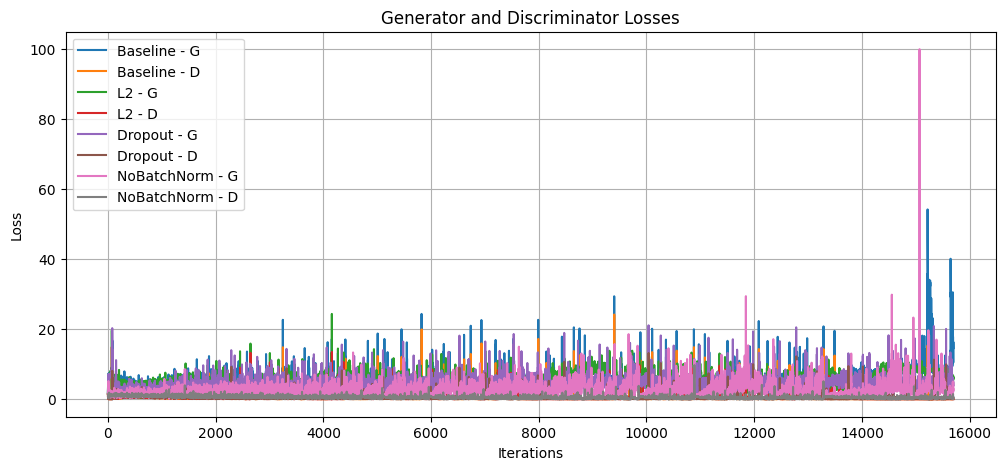

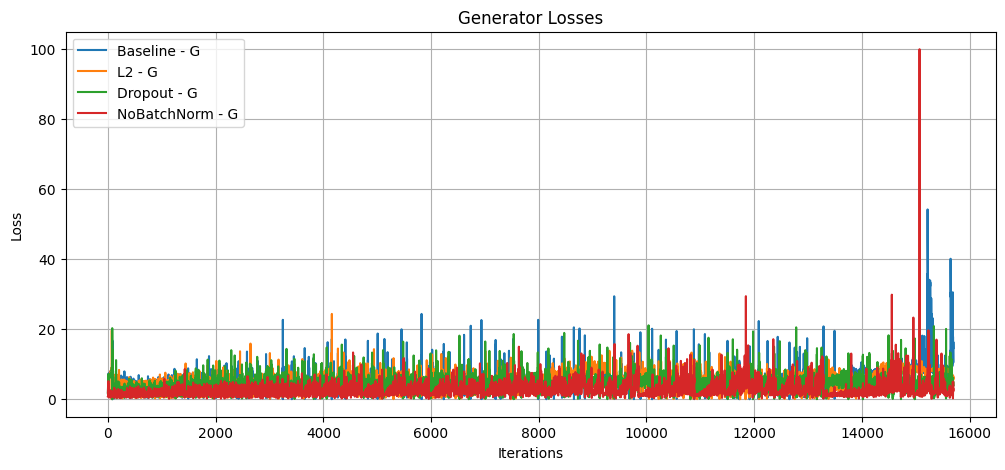

In [10]:
def plot_losses(histories, labels):
    plt.figure(figsize=(12, 5))
    for h, label in zip(histories, labels):
        plt.plot(h['G_losses'], label=f'{label} - G')
        plt.plot(h['D_losses'], label=f'{label} - D')
    plt.title("Generator and Discriminator Losses")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(
    [history_base, history_l2, history_dropout, history_bn],
    ["Baseline", "L2", "Dropout", "NoBatchNorm"]
)


def plot_generator_losses(histories, labels):
    plt.figure(figsize=(12, 5))
    for h, label in zip(histories, labels):
        plt.plot(h['G_losses'], label=f'{label} - G')
    plt.title("Generator Losses")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_generator_losses(
    [history_base, history_l2, history_dropout, history_bn],
    ["Baseline", "L2", "Dropout", "NoBatchNorm"]
)


Generated Image Comparison

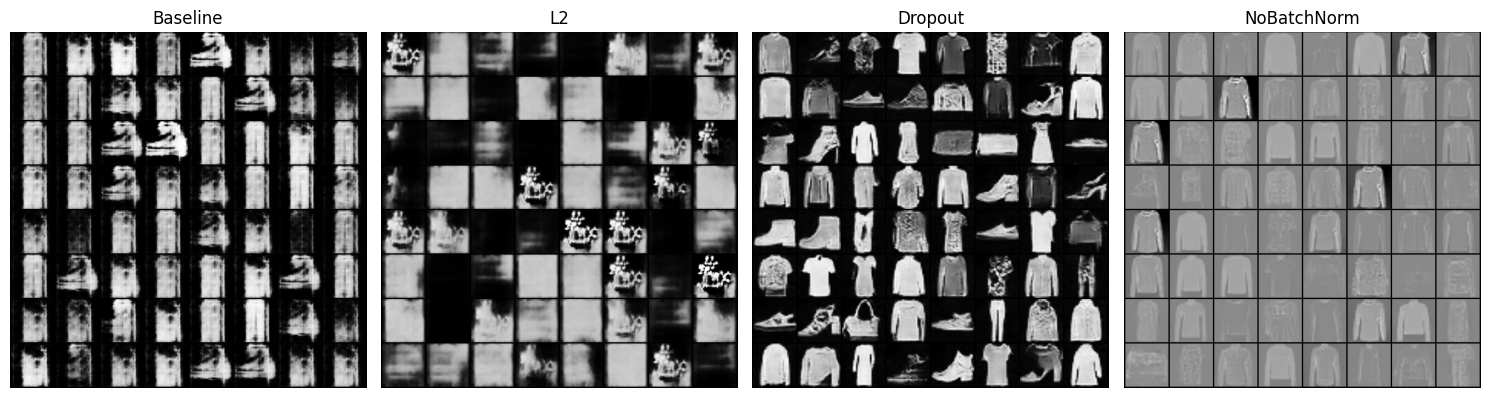

In [11]:
def show_generated_images(histories, labels, epoch=-1):
    fig, axs = plt.subplots(1, len(histories), figsize=(15, 5))
    for i, (h, label) in enumerate(zip(histories, labels)):
        img = h["images"][epoch]
        axs[i].imshow(img.permute(1, 2, 0).numpy())
        axs[i].set_title(label)
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

show_generated_images(
    [history_base, history_l2, history_dropout, history_bn],
    ["Baseline", "L2", "Dropout", "NoBatchNorm"]
)

FID

In [12]:
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms as T
import torch.nn.functional as F

# --- Helpers ---
denorm = T.Normalize((-1,), (2,))
def prep_images(imgs):
    # denormalize → [0,1], resize to 299×299, repeat channels
    imgs = denorm(imgs).clamp(0, 1)
    imgs = F.interpolate(imgs, size=(299, 299), mode='bilinear', align_corners=False)
    return imgs.repeat(1, 3, 1, 1)

# Collect one batch of 128 real images (to CPU/GPU)
real_list = []
count = 0
for imgs, _ in dataloader:
    real_list.append(imgs)
    count += imgs.size(0)
    if count >= 128:
        break
real_imgs = torch.cat(real_list, dim=0)[:128].to(device)
real_imgs = prep_images(real_imgs)

# --- FID computation ---
def compute_fid(models_dict, num_samples=128, step=32):
    fid_scores = {}
    for label, netG in models_dict.items():
        fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
        fid.update(real_imgs, real=True)

        netG.eval()
        seen = 0
        with torch.no_grad():
            while seen < num_samples:
                b = min(step, num_samples - seen)
                noise = torch.randn(b, nz, device=device)
                fake = netG(noise)
                fake = prep_images(fake)
                fid.update(fake, real=False)
                seen += b

        score = fid.compute().item()
        fid_scores[label] = round(score, 2)

    return fid_scores

# --- Run it for Dropout and NoBatchNorm ---
models_to_eval = {
    "Baseline":     netG_base,
    "L2":           netG_l2,
    "Dropout":      netG_dropout,
    "NoBatchNorm":  netG_bn
}

fid_results = compute_fid(models_to_eval)
print("FID Scores:", fid_results)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 319MB/s]


FID Scores: {'Baseline': 385.04, 'L2': 385.59, 'Dropout': 177.26, 'NoBatchNorm': 192.99}
